In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import seaborn as sns

import math
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pytz
from datetime import datetime
import time

import collections
from wordcloud import WordCloud

In [169]:
import settings
import mysql.connector
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly
import random
import plotly.express as px
from IPython.display import clear_output
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
py.init_notebook_mode()

In [4]:
# Filter constants for states in US
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'American Samoa', 'AS', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', 'Delaware', 'DE', 'District of Columbia', 'DC', 'Federated States of Micronesia', 'FM', 'Florida', 'FL', 'Georgia', 'GA', 'Guam', 'GU', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Marshall Islands', 'MH', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Northern Mariana Islands', 'MP', 'Ohio', 'OH', 'Oklahoma', 'OK', 'Oregon', 'OR', 'Palau', 'PW', 'Pennsylvania', 'PA', 'Puerto Rico', 'PR', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virgin Islands', 'VI', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())

In [100]:
# Read json data containing tweets
tweets_data_path = 'elite.json'

with open(tweets_data_path) as f:
  tweets_data = json.load(f)


In [101]:
print("The total number of Tweets is:",len(tweets_data))
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(tweets_data[0])

The total number of Tweets is: 34
{   'coordinates': None,
    'created_at': '2020-03-16T18:42:42',
    'favorites_count': 0,
    'geo': None,
    'id': 1,
    'id_str': '1239623140906500098',
    'in_reply_to': None,
    'polarity': 0.0,
    'retweet_count': 0,
    'subjectivity': 0.0,
    'text': 'Yes no maybe @AEWrestling: Can #TheLuchaBrothers gain the victory '
            'against #BestFriends this Wednesday night on Dynamite? \n'
            '\n'
            'Which team are you siding…',
    'user_created': '2010-01-03T02:08:49',
    'user_description': 'I am a proud supporter of the Philadelphia Eagles, '
                        'Miami Heat, New York Yankees, Jimmie Johnson and the '
                        'Beautiful People (The Allüre). Snapchat: '
                        'TheBlazingMars',
    'user_followers_count': 597,
    'user_friends_count': 295,
    'user_location': 'Waterbury, Connecticut',
    'user_name': 'StarlightRoad'}


In [150]:
# Convert json to dataframe
tweets_df = pd.read_json(tweets_data_path, orient='columns')

In [151]:
#tweets_df.head()
tweets_df['in_reply_to'] = tweets_df['in_reply_to'].apply(lambda i : i or '')

In [152]:
# clean the text, remove \n and special characters and emojis
tweets_df['text'] = tweets_df['text'].apply(lambda text: re.sub(r"\n", " ", text))
tweets_df['text'] = tweets_df['text'].apply(lambda text: text.encode('ascii', 'ignore').decode('ascii'))

In [153]:
# add column is_retweet
tweets_df['is_retweet'] = tweets_df['text'].apply(lambda x: False if 'RT' not in x else True)

In [183]:
# convert created_at and user_created time to CST
#tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format = '%Y-%m-%d %H:%M:%S')
#tweets_df['created_at'] = tweets_df['created_at'].dt.tz_localize('utc')
#tweets_df['created_at'] = tweets_df['created_at'].dt.tz_convert('US/Central')
# tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], format = '%Y-%m-%d %H:%M:%S')
# tweets_df['user_created'] = tweets_df['user_created'].dt.tz_localize('utc')
# tweets_df['user_created'] = tweets_df['user_created'].dt.tz_convert('US/Central')
tweets_df.head()

id          created_at               id_str  \
0   1 2020-03-16 18:42:42  1239623140906500096   
1   2 2020-03-16 18:43:26  1239623326806560768   
2   3 2020-03-16 18:43:46  1239623407211294720   
3   4 2020-03-16 18:43:52  1239623433048244224   
4   5 2020-03-16 18:44:05  1239623488861863936   

                                                text in_reply_to  \
0  Yes no maybe @AEWrestling: Can #TheLuchaBrothe...               
1  Brandy rhodes has really great #tits . DM me i...               
2  RT @AEWRetweeting: Its time for a Monday #Foll...               
3  RT @CodyRhodes: Brand new #aew Road To... toni...               
4  RT @floranfauna789: Brandy rhodes has really g...               

        user_name            user_location  \
0   StarlightRoad   Waterbury, Connecticut   
1  floranfauna789                     None   
2       Tink4u920             Florida, USA   
3    crazypete315                   Oldham   
4    AaronNowak13  Southeast Michigan, USA   

                                    user_description         user_created  \
0  I am a proud supporter of the Philadelphia Eag...  2010-01-03T02:08:49   
1                                               None  2012-06-25T03:47:10   
2  @GrimsToyShow #1 fan and @wwe fan 4 life Futur...  2017-08-09T03:57:02   
3  just normal guy who can be alittle silly and a...  2015-02-05T17:00:03   
4  Secret account, was supposed to delete but I c...  2019-12-10T14:01:07   

   geo  coordinates  user_followers_count  user_friends_count  retweet_count  \
0  NaN          NaN                   597                 295              0   
1  NaN          NaN                    57                  22              0   
2  NaN          NaN                   334                1411              0   
3  NaN          NaN                  1085                1054              0   
4  NaN          NaN                   358                2849              0   

   favorites_count  polarity  subjectivity  is_retweet  
0                0  0.000000      0.000000       False  
1                0  0.200000      0.675000       False  
2                0  0.000000      1.000000        True  
3                0  0.170455      0.454545        True  
4                0  0.200000      0.675000        True

In [165]:
# Compute # of RT's, @'s, and text tweets
retweet_tweets = tweets_df[tweets_df['is_retweet'] == True]
response_tweets = tweets_df[tweets_df['in_reply_to']!='']
mention_tweets = tweets_df[~tweets_df['text'].str.contains("RT")  & tweets_df['text'].str.contains("@")]
mention_tweets = mention_tweets[mention_tweets['in_reply_to']==""]
text_tweets = tweets_df[~tweets_df['text'].str.contains("@")  & ~tweets_df['text'].str.contains("RT")]
url_tweets = tweets_df[tweets_df['text'].str.contains("http")]

print("Total number of tweets:", len(tweets_df))
print("Total number of retweets:", len(retweet_tweets))
print("Total number of response tweets:", len(response_tweets))
print("Total number of tweets with mentions that are not retweets or responses:", len(mention_tweets))
print("Total number of text tweets:", len(text_tweets))
print("Number of tweets containing URL links:", len(url_tweets))
print("Number of different users:", tweets_df['user_name'].nunique())
print("Number of tweets per user:", len(tweets_df)/tweets_df['user_name'].nunique())

Total number of tweets: 34
Total number of retweets: 20
Total number of response tweets: 1
Total number of tweets with mentions that are not retweets or responses: 1
Total number of text tweets: 12
Number of tweets containing URL links: 20
Number of different users: 27
Number of tweets per user: 1.2592592592592593


In [167]:
values = [ len(retweet_tweets), len(response_tweets), len(mention_tweets), len(text_tweets)]
labels = ['Retweets', 'Responses', 'Mentions', 'Text tweets']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [14]:
# Find most used hashtags
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(tweets_df['text'].apply(hashtag_pattern.findall))
hashtag_words = []
for match in hashtag_matches:
    for word in match:
        hashtag_words.append(word.lower())

In [15]:
# hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
# hashtag_ordered_list = hashtag_ordered_list[::-1]
# hashtag_ordered_values = []
# hashtag_ordered_keys = []
# for item in hashtag_ordered_list[0:50]:
#     hashtag_ordered_keys.append(item[0])
#     hashtag_ordered_values.append(item[1])

In [176]:
# fig, ax = plt.subplots(figsize = (12,12))
# y_pos = np.arange(len(hashtag_ordered_keys))
# ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'green', edgecolor = 'black', linewidth=1)
# ax.set_yticks(y_pos)
# ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
# ax.set_xlabel("Nº of appereances")
# ax.set_title("Most used #hashtags", fontsize = 20)
# plt.tight_layout(pad=3)
# plt.show()
fdist = FreqDist(hashtag_words)
fd = pd.DataFrame(fdist.most_common(100), columns = ["Word","Frequency"]).reindex()
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
data = [trace]
py.iplot(data)

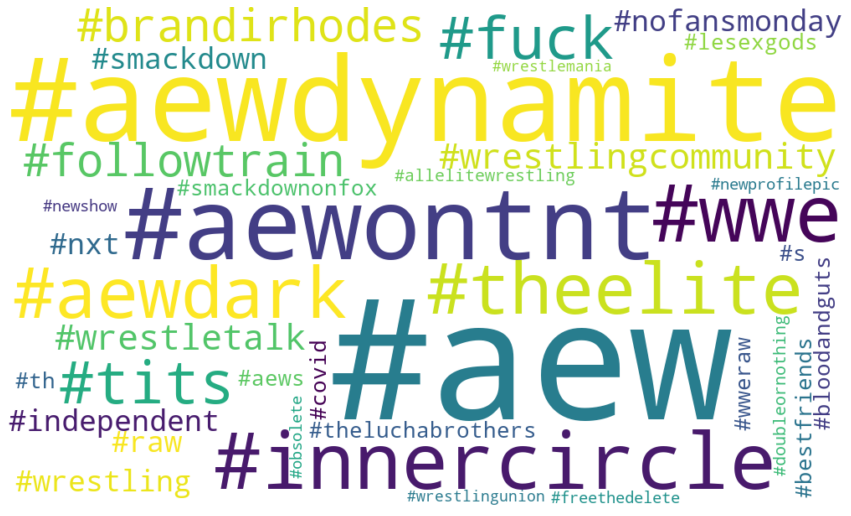

In [17]:
#Make a wordcloud plot of the most used hashtags
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
# Find most mentioned accounts
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(tweets_df['text'].apply(mention_pattern.findall))
mentioned_accounts = []
for match in mention_matches:
    for word in match:
        mentioned_accounts.append(word.lower())

In [19]:
fdist = FreqDist(mentioned_accounts)
fd = pd.DataFrame(fdist.most_common(100), columns = ["Word","Frequency"])
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
data = [trace]
py.iplot(data)

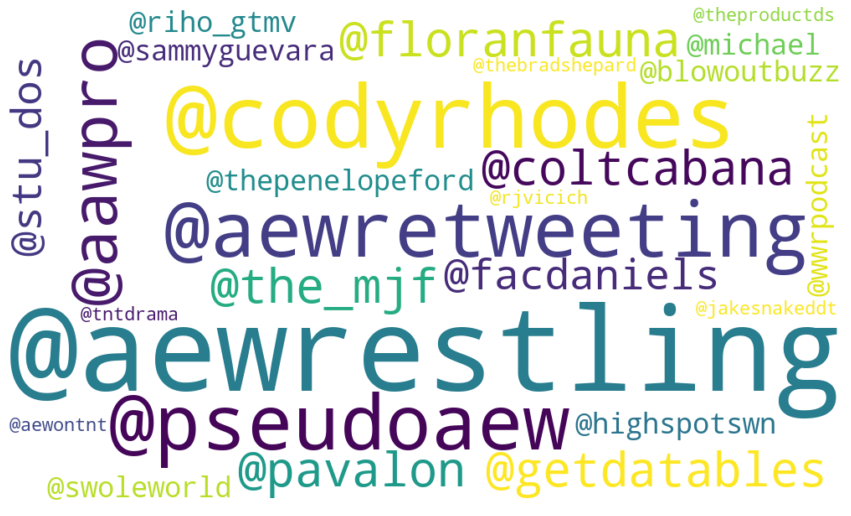

In [20]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [21]:
words = []
words_filtered = []
words = ' '.join(tweets_df["text"])
words = re.sub(r"http\S+", "", words)
words = words.replace('RT ', ' ').replace('&amp;', 'and')
words = re.sub('[^A-Za-z0-9]+', ' ', words)
words = words.lower()
tokenized_words = word_tokenize(words)
stopword_list=set(stopwords.words("english"))
#stopword_list.add("")
for word in tokenized_words:
    if word not in stopword_list:
        if "@"+word not in mentioned_accounts:#exclude accounts
            if "#"+word not in hashtag_words:#exclude hashtags
                words_filtered.append(word)


In [22]:
fdist = FreqDist(words_filtered)
fd = pd.DataFrame(fdist.most_common(100), columns = ["Word","Frequency"])#.drop([0]).reindex()
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
data = [trace]
py.iplot(data)

In [23]:
is_in_US=[]
geo = tweets_df[['user_location']]
tweets_df = tweets_df.fillna(" ")
for x in tweets_df['user_location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(None)
is_in_US
geo_dist = pd.DataFrame(is_in_US, columns=['State']).dropna().reset_index()
geo_dist = geo_dist.groupby('State').count().rename(columns={"index": "Number"}) \
        .sort_values(by=['Number'], ascending=False).reset_index()
geo_dist["Log Num"] = geo_dist["Number"].apply(lambda x: math.log(x, 2))
geo_dist['Full State Name'] = geo_dist['State'].apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' + 'Num: ' + geo_dist['Number'].astype(str)

fig = go.Figure(data=go.Choropleth(
    locations=geo_dist['State'], # Spatial coordinates
    z = geo_dist['Number'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Number of tweets",
))
fig.update_layout(
    title_text = 'Tweets by User Location',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

In [24]:
# Time series
total = tweets_df.groupby(pd.Grouper(key='created_at', freq='60s')).count().reset_index()
total = total.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
time_series = total["Time in CST"].reset_index(drop=True)
result = tweets_df.groupby([pd.Grouper(key='created_at', freq='60s'), 'polarity']).count().unstack(fill_value=0).stack().reset_index()
result = result.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
# time_series = result["Time in CST"][result['polarity']==0].reset_index(drop=True)

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_series,
    y=total["Num of tweets"],
    name="Total",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['polarity']==0].reset_index(drop=True),
    name="Neural",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['polarity']>0].reset_index(drop=True),
    name="Negative",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['polarity']<0].reset_index(drop=True),
    name="Positive",
    opacity=0.8))
fig.show()

In [26]:
print("There are {} different users".format(tweets_df['user_name'].nunique()))

There are 27 different users


In [42]:
user_tweets = tweets_df.groupby('user_name').count()
user_tweets = user_tweets.rename(columns={"text":"count"}).reset_index()
user_tweets.head()

user_name  id  created_at  id_str  count  in_reply_to  user_location  \
0     AEWFanGuy18   1           1       1      1            1              1   
1    AaronNowak13   1           1       1      1            1              1   
2  AvgMansReviews   2           2       2      2            2              2   
3     Blkdemon316   1           1       1      1            1              1   
4   Broken_G_Funk   2           2       2      2            2              2   

   user_description  user_created  geo  coordinates  user_followers_count  \
0                 1             1    1            1                     1   
1                 1             1    1            1                     1   
2                 2             2    2            2                     2   
3                 1             1    1            1                     1   
4                 2             2    2            2                     2   

   user_friends_count  retweet_count  favorites_count  polarity  subjectivity  \
0                   1              1                1         1             1   
1                   1              1                1         1             1   
2                   2              2                2         2             2   
3                   1              1                1         1             1   
4                   2              2                2         2             2   

   is_retweet  
0           1  
1           1  
2           2  
3           1  
4           2

In [57]:
fd = user_tweets[["user_name","count"]].sort_values(by=['count'], ascending=False)
trace = go.Bar(x=fd["user_name"], y=fd["count"], name="Freq Dist")
data = [trace]
py.iplot(data)